In [51]:
import pandas as pd
from pathlib import Path
import numpy as np
import hvplot.pandas
import scipy.optimize
import symbol_data
import portfolio_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spx_df = pd.read_csv(Path('./Resources/SPX.csv'), 
                    index_col='Date', 
                    parse_dates=True,
                    infer_datetime_format=True
                    )
spx_daily_returns = spx_df['Close'].pct_change().dropna()

In [3]:
stocks = ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'CRM', 'DELL', 'DOCU', 'EPAM', 'FIS', 'FISV', 'IBM', 'INFY', 'LRCX', 'MSFT', 'MU', 'NOW', 'NVDA', 'ORCL', 'SAP', 'TEAM', 'TXN', 'WDAY', 'WORK', 'XLNX', 'ZBRA', 'ZEN', 'ZI', 'ZS']
# This function may have to be rewritten to accomodate Anurag's data functions
# as it performs all the analysis within the same loop as retrieving the data.
def stock_data_calculator(stocks):
    # Generate a dataframe of daily returns for S&P 500
    spx_daily_returns = symbol_data.get_historical_data('SPX')
    spx_daily_returns = spx_daily_returns['Close'].pct_change().dropna()
    # Create an empty dictionary to store the stock data
    stock_data_dict = {}
    # This section can be replaced by Anurag's function
    for stock in stocks:
        stock_df = symbol_data.get_historical_data(stock)
        daily_returns = stock_df['Close'].pct_change().dropna()
        daily_returns_df = pd.concat(
            [daily_returns, spx_daily_returns], 
            axis=1,
            join='inner', 
            keys = [stock, 'SPX']
            )
        covariance = daily_returns_df[stock].cov(daily_returns_df['SPX'])
        beta = covariance / daily_returns_df['SPX'].var()

        std = daily_returns.std()

        var = daily_returns.var()

        expected_return = .035 + beta*(.1-.035)
        
        stock_data_dict[stock] = {'expected_return': expected_return, 'std': std, 'var': var, 'beta': beta}
    return stock_data_dict

        


In [4]:
stock_data_calculator(stocks)

{'AAPL': {'expected_return': 0.1021857914988607,
  'std': 0.02079129793240788,
  'var': 0.0004322780697141482,
  'beta': 1.0336275615209338},
 'ACN': {'expected_return': 0.0928258962563413,
  'std': 0.01645928931954835,
  'var': 0.0002709082049045985,
  'beta': 0.8896291731744815},
 'ADBE': {'expected_return': 0.11004981725358733,
  'std': 0.021328535684571374,
  'var': 0.00045490643444803455,
  'beta': 1.1546125731321126},
 'ADI': {'expected_return': 0.10267257755225005,
  'std': 0.01951063375075435,
  'var': 0.0003806648293560747,
  'beta': 1.0411165777269238},
 'ADSK': {'expected_return': 0.11739155821007816,
  'std': 0.024441902649579843,
  'var': 0.0005974066051315382,
  'beta': 1.2675624340012024},
 'AKAM': {'expected_return': 0.1100147458956259,
  'std': 0.027881047884079174,
  'var': 0.0007773528311143157,
  'beta': 1.15407301377886},
 'AMAT': {'expected_return': 0.11417312976324465,
  'std': 0.022677234403613647,
  'var': 0.0005142569601964385,
  'beta': 1.2180481502037637},
 

In [5]:
def portfolio_expected_return_calculator(stocks, weights):
    # Create an empty list which will hold the expected returns
    expected_returns = []
    # Gather the stock data from the symbol_data_calculator function
    symbol_data = stock_data_calculator(stocks)
    # Pull only the expected returns from the data
    for symbol in symbol_data:
        expected_returns.append(symbol_data[symbol]['expected_return'])
    # Multiply the expected returns by the weights to get weighted expected returns
    weighted_expected_returns = expected_returns * weights
    # Sum all these to get the expected return of the portfolio
    weighted_expected_returns = weighted_expected_returns.sum()
    return weighted_expected_returns 
    
   

In [6]:
weights = np.random.random(32)
weights /= weights.sum()
portfolio_expected_return_calculator(stocks, weights)

0.10446328948288972

In [43]:
def portfolio_variance_calculator(stocks, weights):
    # Retrieve a dataframe of close prices for all stocks entered
    stock_df = portfolio_data.get_portfolio_historical_close_data(stocks)
    # Get the daily returns of each stock
    daily_returns = stock_df.pct_change().dropna()
    
    # Get the covariance array of the portfolio using the .cov() method.
    portfolio_cov = np.array(daily_returns.cov())

    # Get the standard deviation of each asset in the portfolio using the .std() method.
    portfolio_std = np.array(daily_returns.std())

    # Cross multiply the std array with the transposition of itself.
    portfolio_stdT = np.transpose(np.array([portfolio_std]))
    portfolio_std_cp = portfolio_std * portfolio_stdT

    # Get the correlation matrix by dividing the covariance matrix by the standard deviation matrix.
    correlation_matrix = portfolio_cov / portfolio_std_cp

    # Get weighted standard deviation and save the transposition of that array.
    weighted_std = portfolio_std * weights
    weighted_stdT = np.transpose(np.array([weighted_std]))

    # Calculate portfolio variance by first multiplying the covariance matrix by the 
    # weighted standard deviation array. This will give an array which is 
    # 1x<the number of stocks in the portfolio>
    portfolio_var = np.matmul(weighted_std, correlation_matrix)
    # Then multiplying that array by the transposition of the weighted standard deviation array.
    # This will give a single value.
    portfolio_var = np.matmul(portfolio_var, weighted_stdT)
    # And finally taking the square root of that value.
    portfolio_var = np.sqrt(portfolio_var)
    return portfolio_var




In [8]:
weights = np.random.random(32)
weights /= weights.sum()
portfolio_variance_calculator(weights, stocks)


array([0.01719175])

In [9]:
def portfolio_performance_calculator(stocks, weights):
    # Retrieve the closing price data for the stocks entered.
    stocks_df = portfolio_data.get_portfolio_historical_close_data(stocks)
    # Calculate the daily returns for each stock.
    daily_returns = stocks_df.pct_change().dropna()
    # Calculate cumulative returns for each stock in the portfolio.
    cumulative_returns = (1+daily_returns).cumprod() - 1
    # Multiply each stock by its respective weight.
    cumulative_returns = cumulative_returns * weights
    # Sum all the weighted cumulative returns
    cumulative_returns = cumulative_returns.sum(axis=1)
    return cumulative_returns

In [10]:
weights = np.random.random(32)
weights /= weights.sum()
portfolio_performance_calculator(stocks,weights)

Date
2020-06-05    0.015785
2020-06-08    0.026327
2020-06-09    0.029839
2020-06-10    0.045462
2020-06-11   -0.014624
                ...   
2020-11-16    0.269405
2020-11-17    0.273744
2020-11-18    0.261902
2020-11-19    0.287062
2020-11-20    0.279087
Length: 119, dtype: float64

In [11]:
# This function accepts a list of stocks and a list of weights which must be in the 
# same order. It will return the 95% confidence interval for annual performance
# of the portfolio.
def portfolio_95percent_confidence_calculator(stocks, weights):
    expected_return = portfolio_expected_return_calculator(stocks, weights)
    variance = portfolio_variance_calculator(stocks, weights)
    lower_bound = expected_return - 2*variance
    upper_bound = expected_return + 2*variance
    return lower_bound, upper_bound

In [12]:
(stocks, weights)

(['AAPL',
  'ACN',
  'ADBE',
  'ADI',
  'ADSK',
  'AKAM',
  'AMAT',
  'AMD',
  'CRM',
  'DELL',
  'DOCU',
  'EPAM',
  'FIS',
  'FISV',
  'IBM',
  'INFY',
  'LRCX',
  'MSFT',
  'MU',
  'NOW',
  'NVDA',
  'ORCL',
  'SAP',
  'TEAM',
  'TXN',
  'WDAY',
  'WORK',
  'XLNX',
  'ZBRA',
  'ZEN',
  'ZI',
  'ZS'],
 array([0.02953124, 0.05908622, 0.03471716, 0.05438993, 0.01977879,
        0.00294125, 0.04471038, 0.06549556, 0.05067963, 0.0135696 ,
        0.00710522, 0.00275383, 0.05193931, 0.00868728, 0.03061307,
        0.03671745, 0.03295323, 0.06128006, 0.00782302, 0.00385079,
        0.02213325, 0.01800974, 0.01633174, 0.06386455, 0.03900613,
        0.05400723, 0.02690318, 0.00471723, 0.00253657, 0.05362073,
        0.01627297, 0.06397366]))

In [59]:
def efficient_frontier_generator(stocks):
    i = 0
    portfolio_dict = {}
    while i < 1000:
        weights = np.random.random(32)
        weights /= weights.sum()
        portfolio_return = portfolio_expected_return_calculator(stocks, weights)
        portfolio_variance = portfolio_variance_calculator(stocks, weights)
        portfolio_dict[i] = (portfolio_return, portfolio_variance, weights)
        i += 1
    return portfolio_dict



In [14]:
# Takes a naive approach to finding the portfolio with the minimum risk.
# There is a way to minimize a function with SciPy.optimize.minimize but 
# I can't figure out how to do it. 
# This function takes a list of stocks and creates 100 random portfolios
# and returns the one with the minimum risk.
def naive_minimum_risk_finder(stocks):
    # Create an iterator
    i = 0
    # Create dictionary to store the minimum risk portfolio
    min_risk = {}
    # Generate 100 portfolios with random weightings.
    # Save only the one with the minimim risk.
    while i < 100:
        weights = np.random.random(len(stocks))
        weights /= weights.sum()
        risk = portfolio_variance_calculator(stocks, weights)
        if not min_risk:
            min_risk['min_risk']={'risk':risk, 'weights':weights}
        elif risk < min_risk['min_risk']['risk']:
            min_risk['min_risk']={'risk':risk, 'weights':weights}
        i += 1
    return min_risk


In [15]:
#naive_minimum_risk_finder(stocks)

In [63]:
# Takes a naive approach to finding the portfolio with the minimum risk.
# There is a way to minimize a function with SciPy.optimize.minimize but 
# I can't figure out how to do it. 
# This function takes a list of stocks and creates 100 random portfolios
# and returns the one with the maximum return.
def naive_maximum_return_finder(stocks):
    i = 0
    # Create dictionary to store the maximum return portfolio
    max_return = {}
    # Generate 100 portfolios with random weightings.
    # Save only the one with the minimim risk.
    while i < 5000:
        weights = np.random.random(len(stocks))
        weights /= weights.sum()
        returns = portfolio_expected_return_calculator(stocks, weights)
        if not max_return:
            max_return['max_return']={'return':returns, 'weights':weights}
        elif returns > max_return['max_return']['return']:
            max_return['max_return']={'return':returns, 'weights':weights}
        i += 1
    return max_return

In [64]:
result = efficient_frontier_generator(stocks)

In [61]:
print(result)

{0: (0.10777991716826621, array([0.01718615]), array([0.06216485, 0.01965473, 0.04835128, 0.01711371, 0.03297241,
       0.06720497, 0.00247251, 0.04197869, 0.07213728, 0.00620271,
       0.00916262, 0.06468001, 0.00932013, 0.0554715 , 0.02054352,
       0.06733096, 0.00559826, 0.01193898, 0.02864295, 0.03545619,
       0.02599764, 0.0056642 , 0.05195361, 0.0112761 , 0.02190927,
       0.00065944, 0.00283054, 0.01120855, 0.06448616, 0.0414156 ,
       0.04497484, 0.03922578])), 1: (0.10385630729951317, array([0.0160208]), array([0.01992491, 0.02817251, 0.00480655, 0.03890902, 0.02951905,
       0.03085369, 0.00719813, 0.03158572, 0.01490266, 0.06658672,
       0.02387684, 0.063709  , 0.00586533, 0.0361122 , 0.05487576,
       0.04853019, 0.01189414, 0.01349477, 0.02217712, 0.01212002,
       0.02952964, 0.04183179, 0.00542399, 0.0355525 , 0.03512057,
       0.05345815, 0.04798649, 0.06275654, 0.00605838, 0.03281155,
       0.01734663, 0.06700945])), 2: (0.10688298242600891, array([0.01

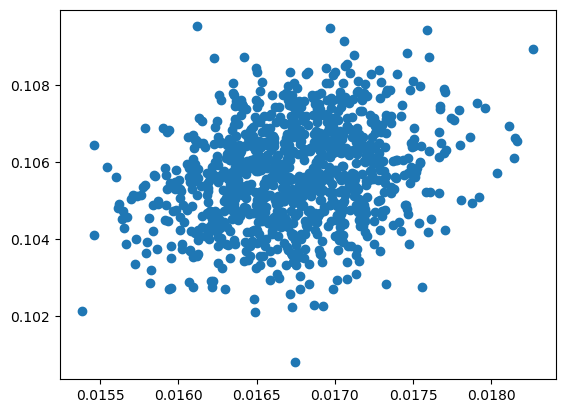

In [62]:
x=[]
y=[]
for k,v in result.items():
    x.append(v[1])
    y.append(v[0])
plt.scatter(x, y)
